In [39]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant
from scipy.linalg import toeplitz, hankel
from IPython.display import clear_output
from scipy.linalg import expm
import time
#### --------- Definition of variables ------------------------

N_size=50001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------


def Create_circulant_slow(array_elements):
    N=len(array_elements)
    T=np.zeros((N,N))
    for i in range(N-1):
        T[i+1,i]=1
    T[0,N-1]=1
    circulant_matrix=array_elements[0]*np.eye(N)
    result=T
    for i in range(1,N):
        circulant_matrix+=result*array_elements[i]
        result=np.matmul(result,T)
    return circulant_matrix

def Create_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements,i))
    return np.array(circulant)

def Create_anti_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements[::-1],-i))
    return np.array(circulant)

display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))



### ----------------------- Fourier theoric ----------------------------------

def Fourier_theoric(random_numbers_m,Gamma,Lambda,N_size):   
    result=np.zeros(N_size)
    index_result=0
    for w in np.arange(-(N_size-1)/2,(N_size-1)/2 +1):
        result[index_result]=random_numbers_m[0]+np.sum([2*random_numbers_m[i]*np.cos(Phi(Gamma,Lambda,2.0*np.pi/N_size * i) - w*2*np.pi/N_size*i) for i in range(1,(N_size-1)//2 +1)]) 
        index_result+=1
    return result

## ------------------ My own fourier transform -------------------------------------
def FT(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    ind_1=0
    for k in np.arange(-(N-1)/2,(N-1)/2+1):
        X[ind_1] = 0.0j
        ind_2=0
        for n in np.arange(-(N-1)/2,(N-1)/2+1):
            X[ind_1] += x[ind_2] *np.exp(-1.0j*(2.0*np.pi/(N))*k*n) #(np.cos((2.0*np.pi/(N))*k*n))#
            #print(n, X[ind_1])
            ind_2+=1
        #print(k,X[ind_1])
        ind_1+=1
    return X

def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f

def plot_interactive(beta,mu):
    plt.figure(figsize=(10,7))
    n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    plt.subplot(2,1,1)
    plt.plot(n,Fermi_dirac(beta,mu,n))
    #plt.ylim(-0.05,1.05)
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.subplot(2,1,2)
    plt.plot(n,Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n),label=r"$\Omega$")
    plt.show()

def Take_portion(matrix,size,copy=True):
    if copy:
        new_matrix=matrix.copy()
        return new_matrix[:size,:size]
    else:
        return matrix[:size,:size]
    
def Binary_entropy(x):
    result=[]
    for i in x:
        if np.abs(i-1)<10E-10:
            result.append(0)
        else:
            result.append(-i*np.log(i)-(1-i)*np.log(1-i))
    return np.array(result)

def Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=0.40824,mu=0,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fft(ifftshift(Mplusband))
    Fourier_minous=fft(ifftshift(Mminousband))
    return Fourier_plus,Fourier_minous
def Toeplitz_matrix(Fourier_plus,L):
    First_column=np.roll(Fourier_plus,-1)[::-1][:L]
    First_row = Fourier_plus[:L]
    return toeplitz(First_column,First_row)
def Hankel_matrix(Fourier_minous,L):
    First_column=Fourier_minous[::-1][:L]
    Last_row=np.roll(Fourier_minous,L-1)[::-1][:L]
    return hankel(First_column,Last_row)


def Covariance_matrix(L,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,N_size=N_size,Ground=False):
    if Ground:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=True)
    else:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=False)
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))/N_size

def Covariance_matrix_from_sub_sample(Fourier_plus,Fourier_minous,L,N_size=N_size):
    return (Toeplitz_matrix(F_plus,L)+Hankel_matrix(F_minous,L))/N_size

In [40]:
tests=100
N_size=5001
L=N_size//100 +1
beta=0.40824
rho=np.zeros((L,L),dtype=np.complex)
#F_plus_total=np.zeros((tests,N_size),dtype=np.complex)
#F_minous_total=np.zeros((tests,N_size),dtype=np.complex)
singular_values=[]
for i in range(tests):
    F_plus,F_minous=Get_Bands_Matrix(N_size=N_size,Ground=False)
    New_cov_matrix=Covariance_matrix_from_sub_sample(F_plus,F_minous,L)
    O_1,S,O_2=np.linalg.svd(New_cov_matrix)
    singular_values.append(S)
    S=-S+0.5
    x=(np.log((1-S)/(S)))
    rho+=expm((O_1@np.diag(x)@O_2))/tests
    #F_plus_total[i,:]=F_plus
    #F_minous_total[i,:]=F_minous

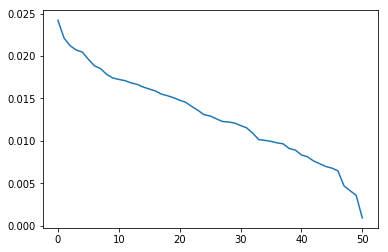

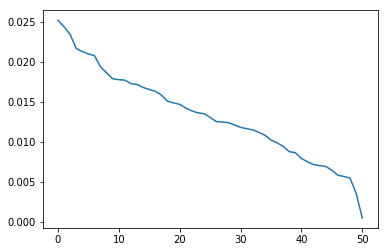

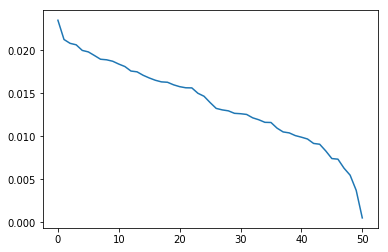

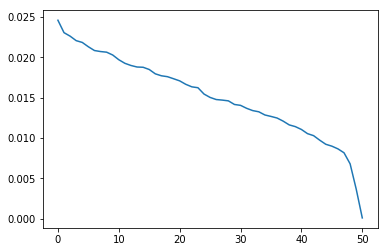

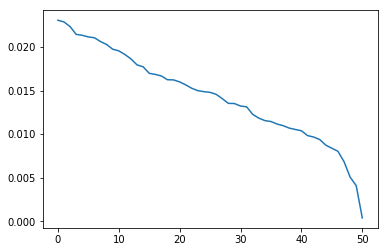

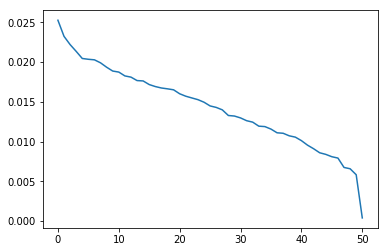

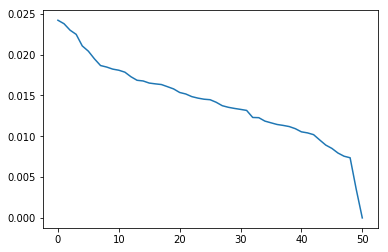

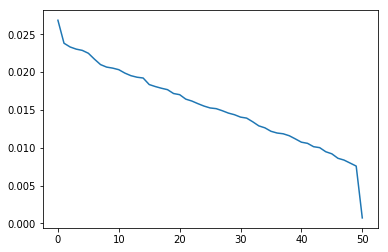

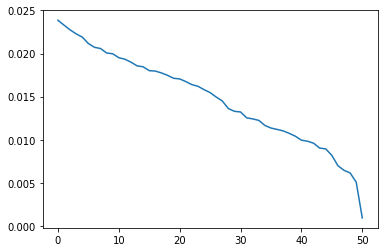

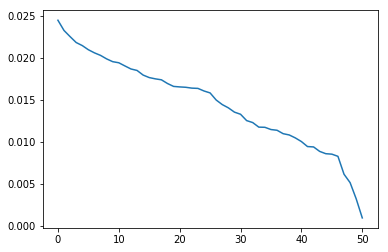

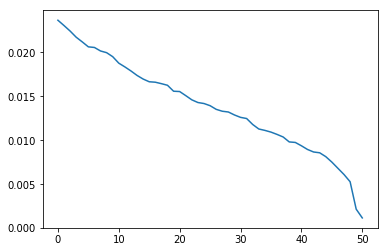

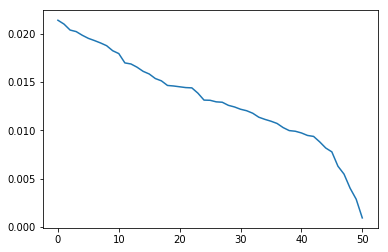

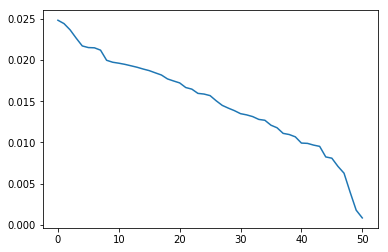

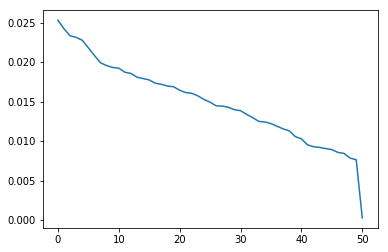

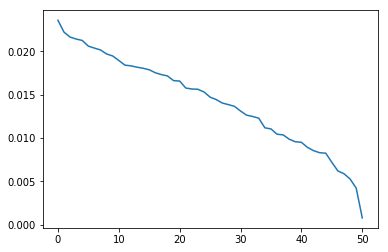

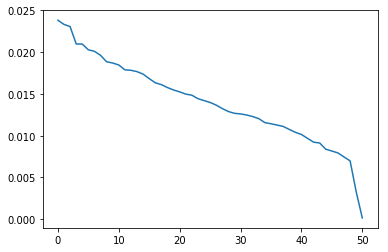

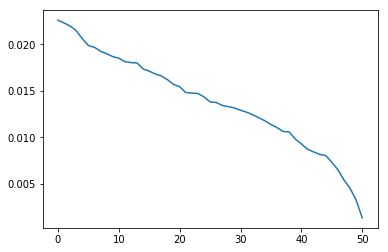

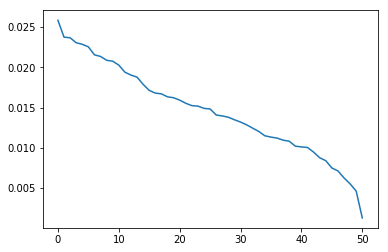

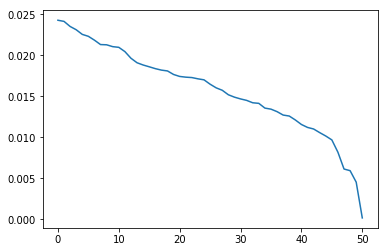

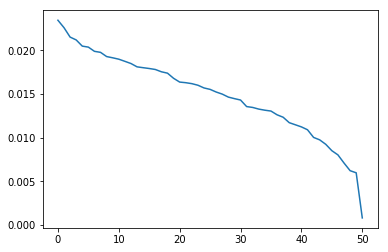

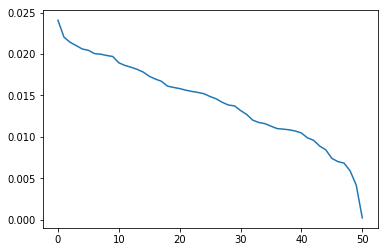

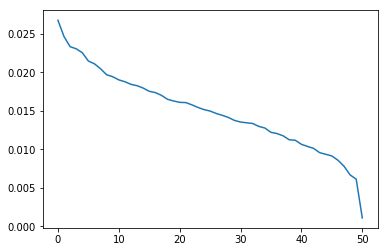

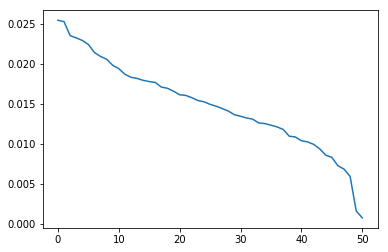

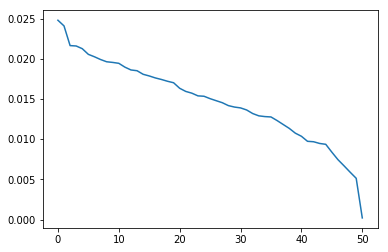

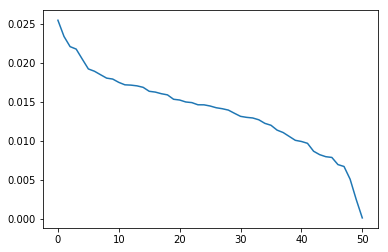

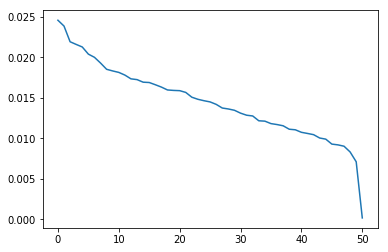

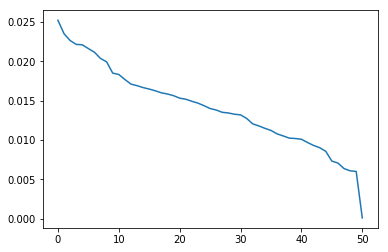

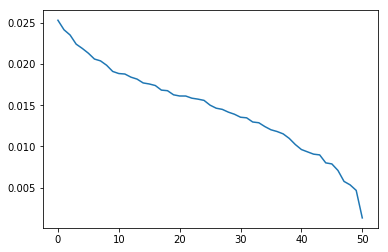

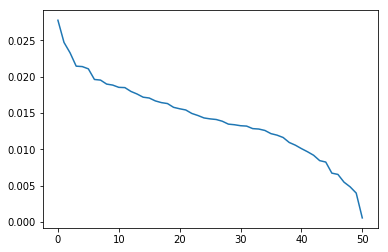

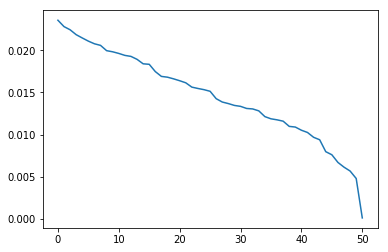

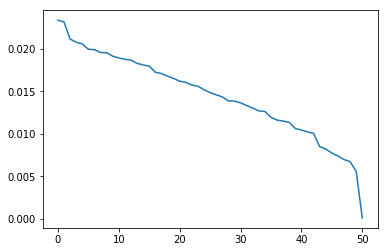

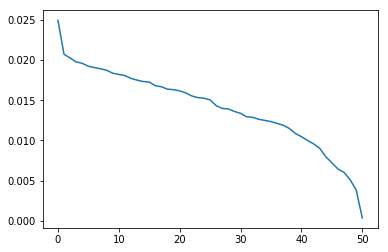

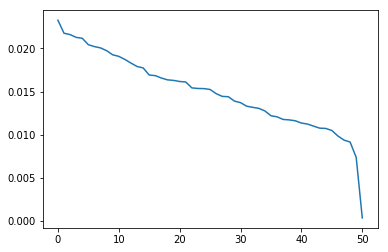

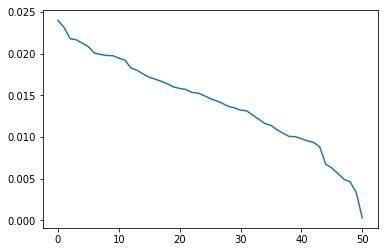

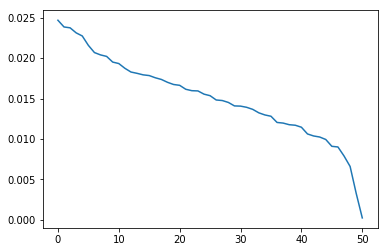

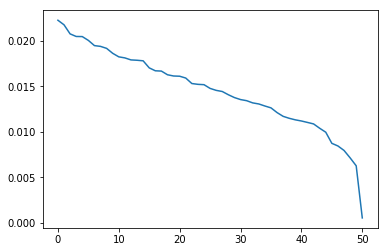

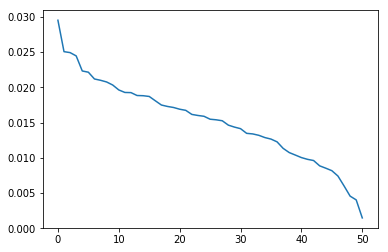

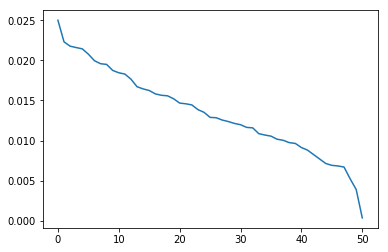

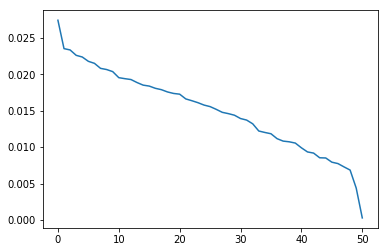

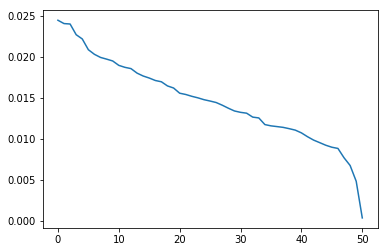

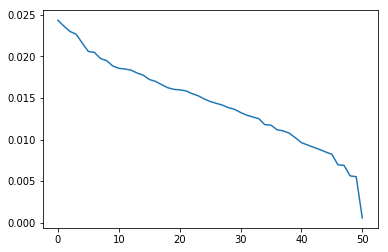

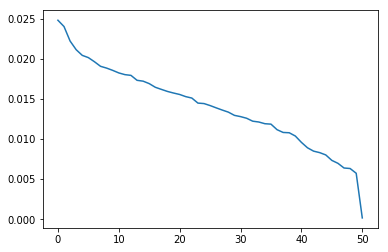

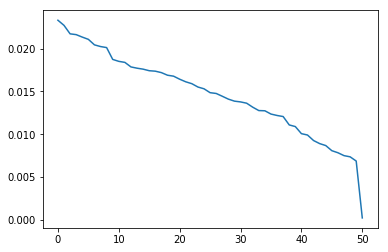

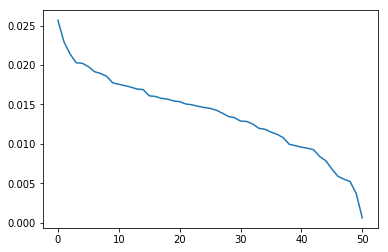

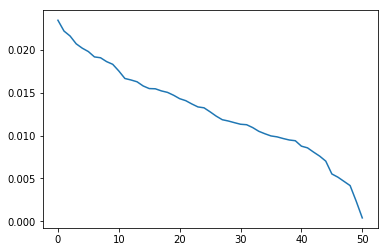

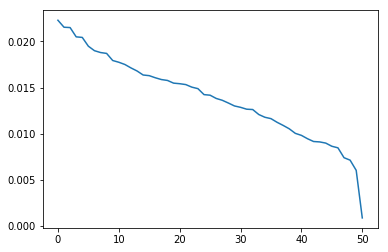

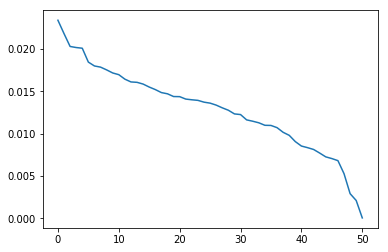

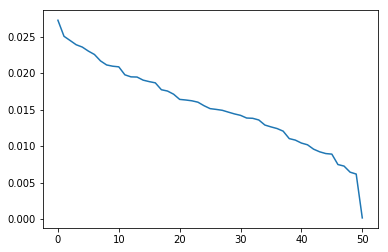

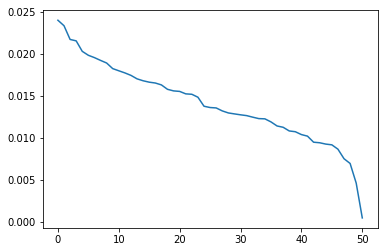

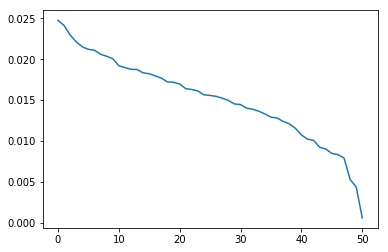

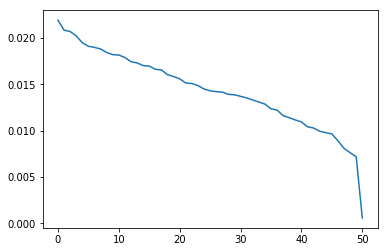

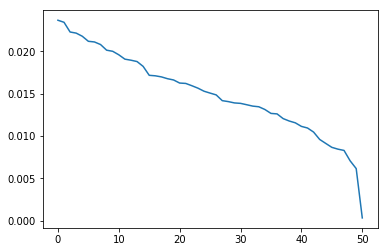

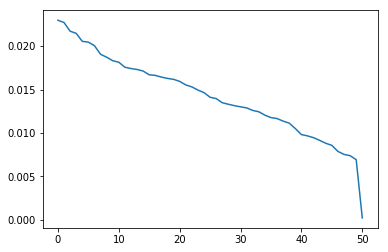

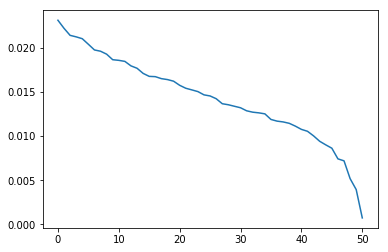

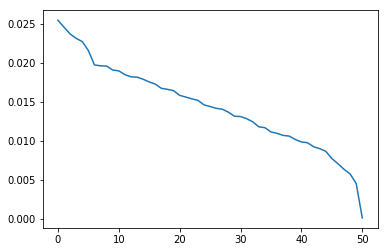

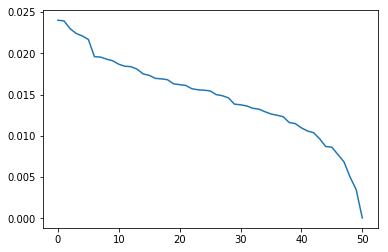

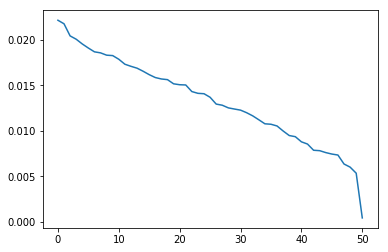

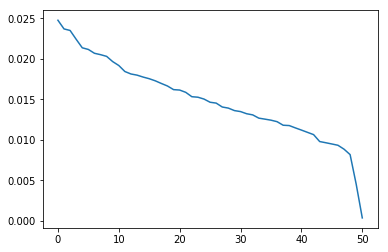

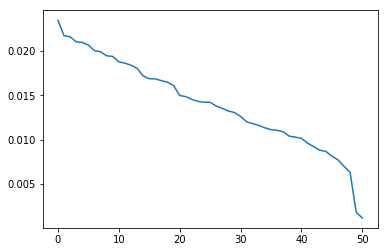

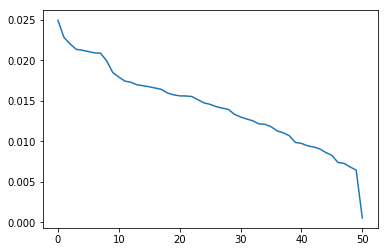

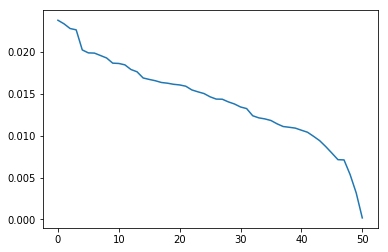

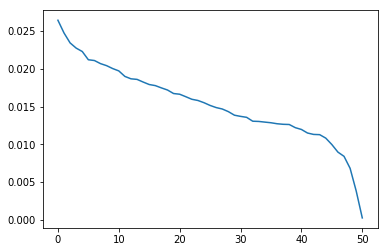

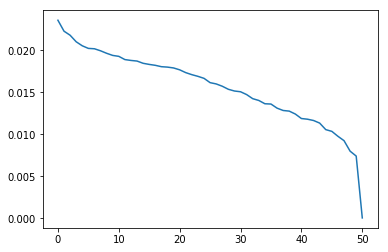

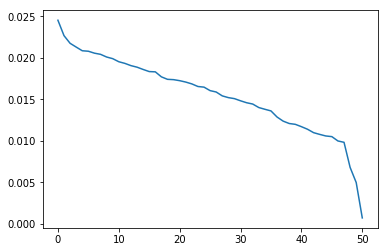

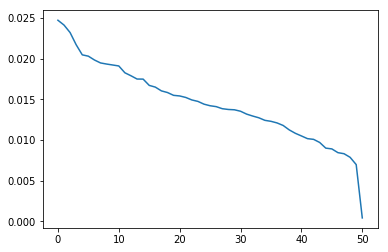

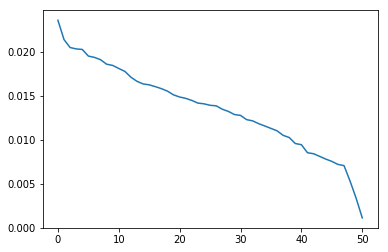

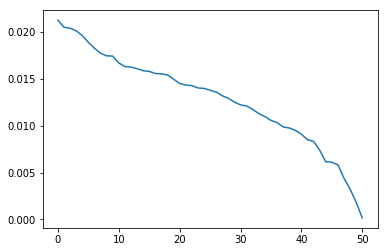

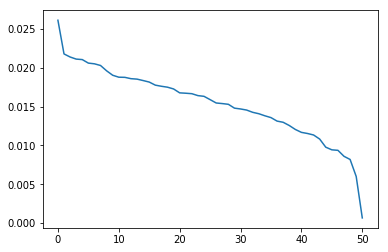

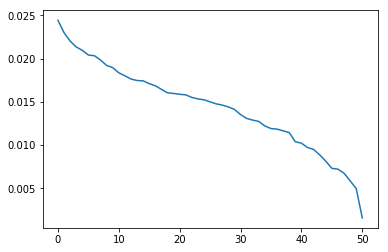

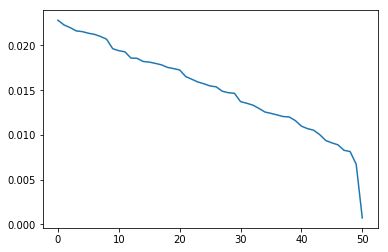

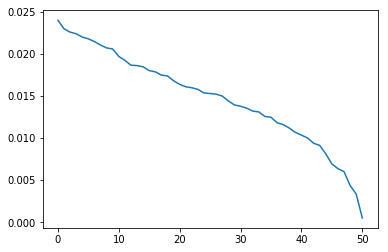

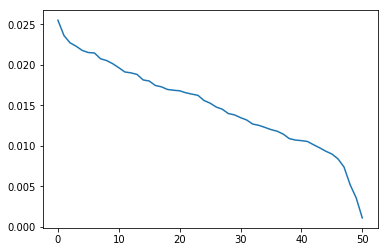

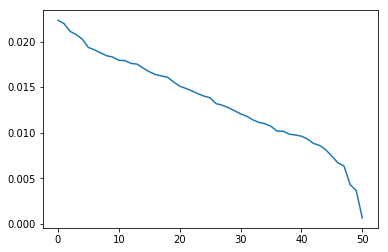

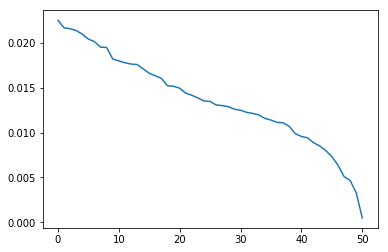

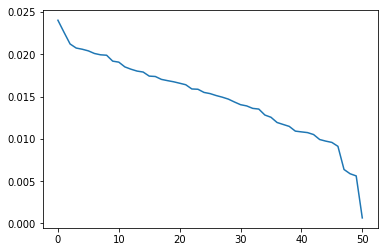

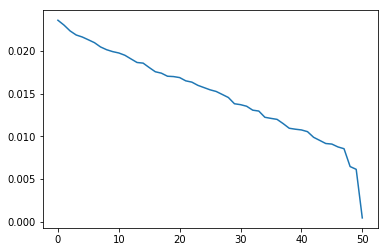

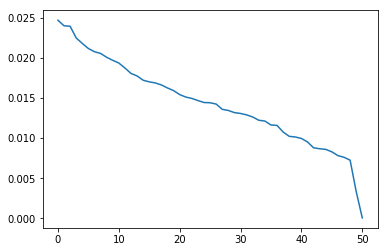

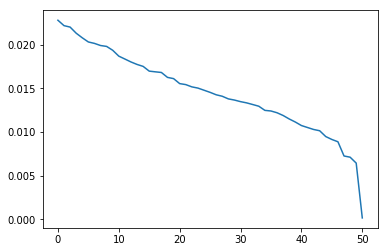

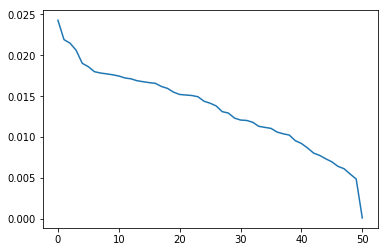

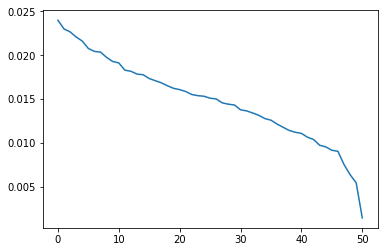

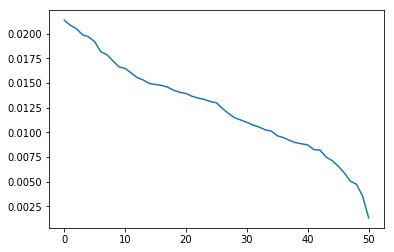

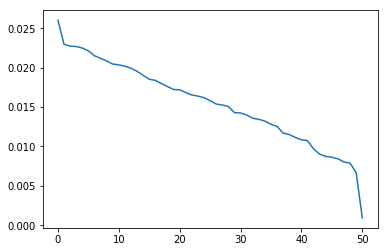

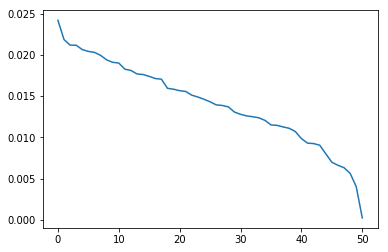

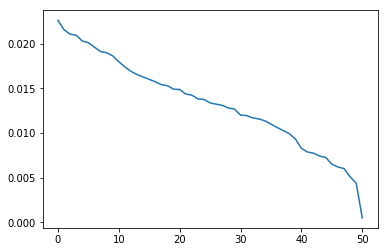

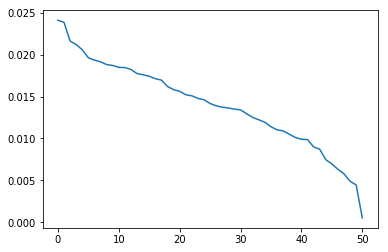

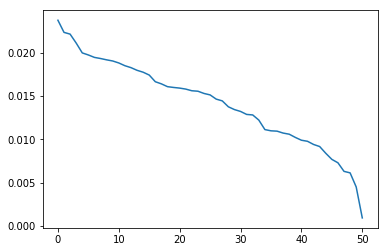

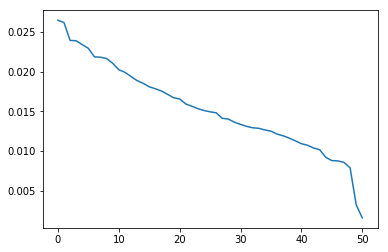

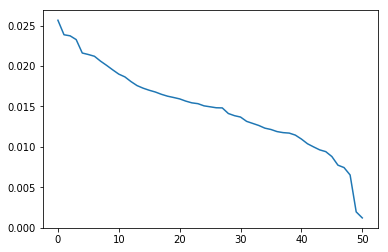

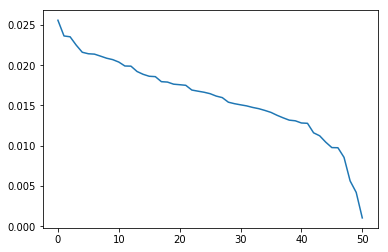

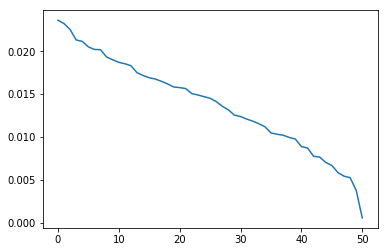

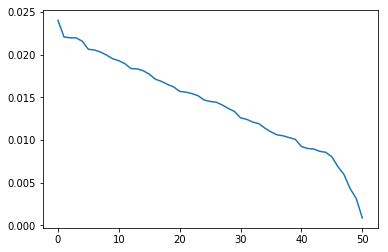

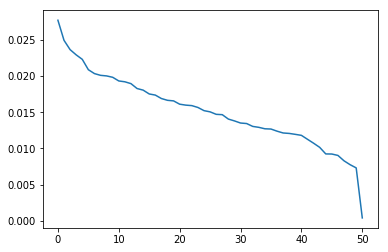

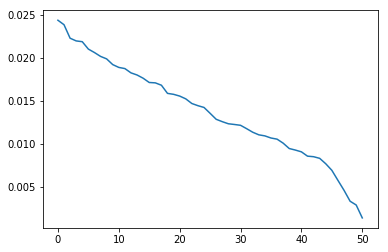

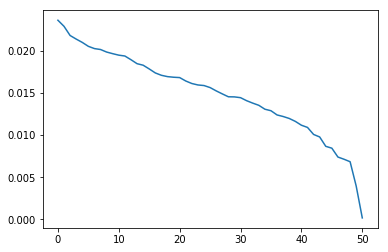

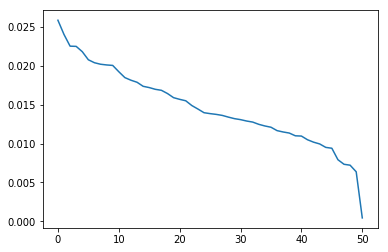

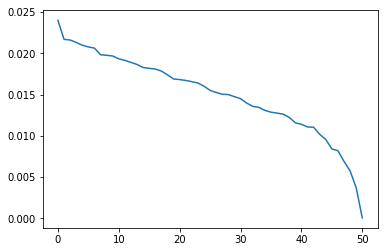

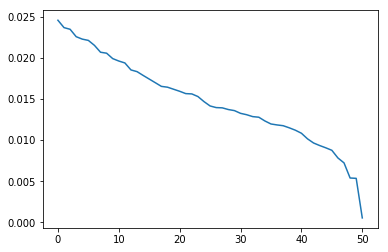

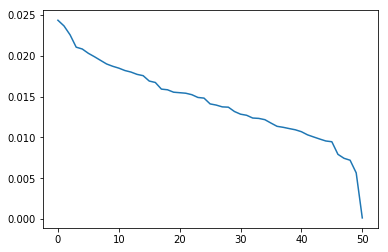

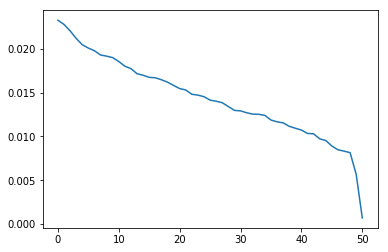

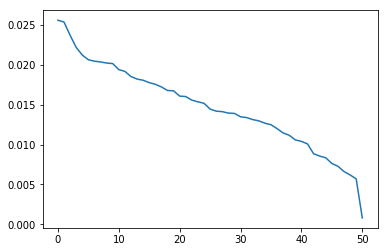

In [51]:
for i in range(tests):
    plt.plot(np.array(singular_values)[i,:])
    plt.show()

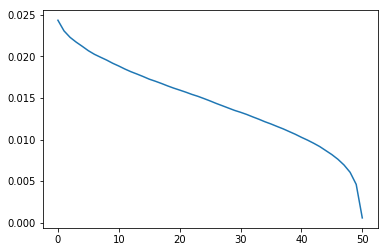

In [57]:
plt.plot(np.mean(np.array(singular_values),axis=0))

# Computing the density matrix

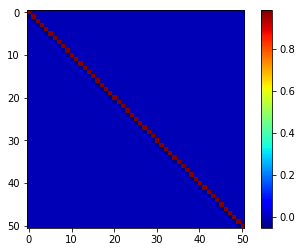

In [35]:
plt.imshow(rho.real,cmap="jet")
plt.colorbar()
plt.show()

In [36]:
import pandas as pd
pd.DataFrame(rho.real[:5,:5]/beta)

,0,1,2,3,4
0,2.408004,-0.015762,0.004984,-0.000693,-0.000247
1,-0.123076,2.408688,-0.017222,0.004773,-0.000696
2,0.048758,-0.124572,2.408539,-0.017231,0.005120
3,-0.005231,0.048579,-0.124592,2.408890,-0.018093
4,-0.008437,-0.005219,0.048914,-0.125451,2.408196


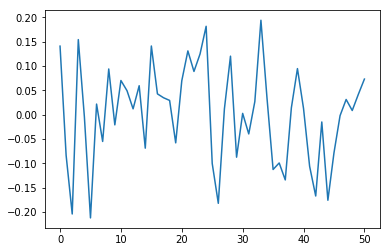

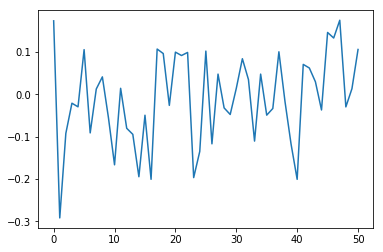

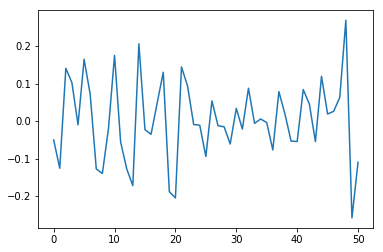

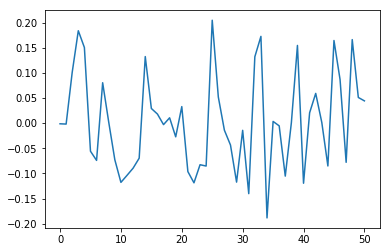

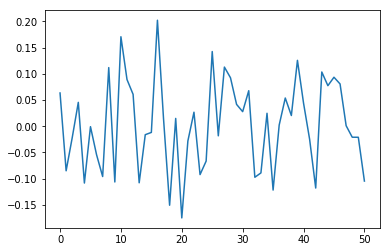

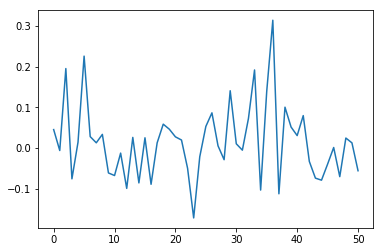

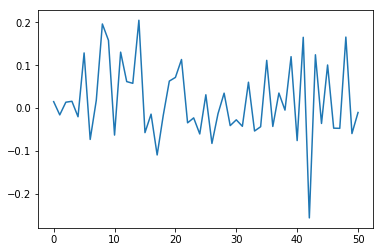

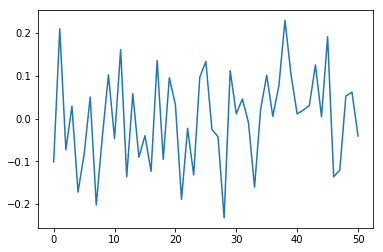

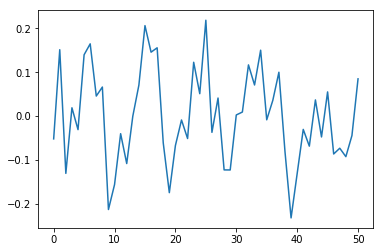

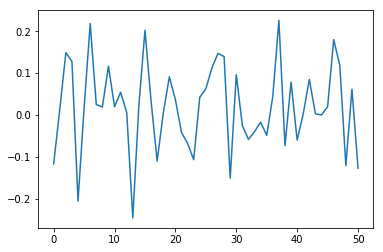

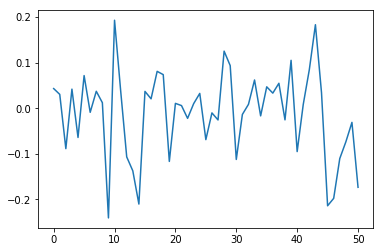

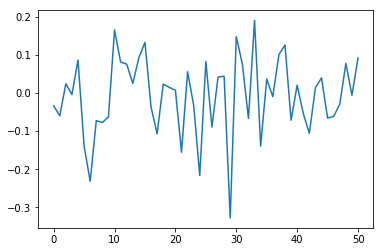

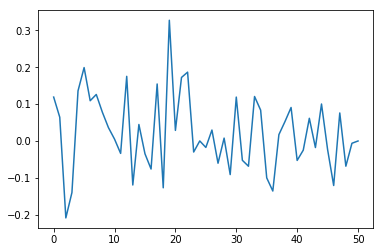

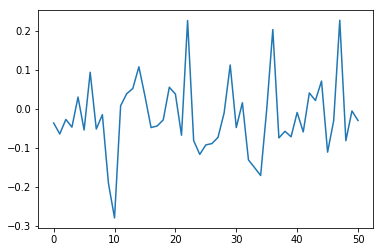

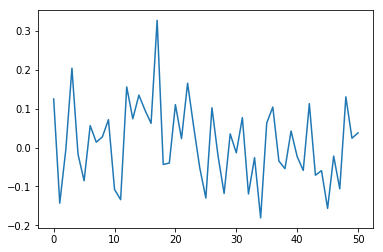

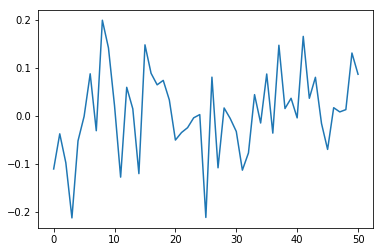

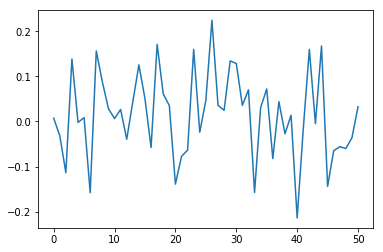

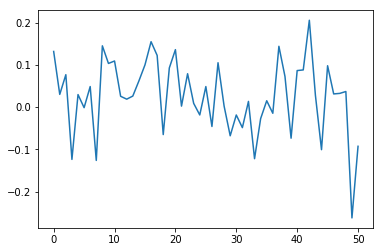

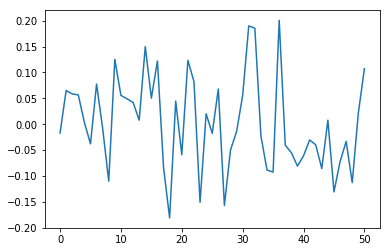

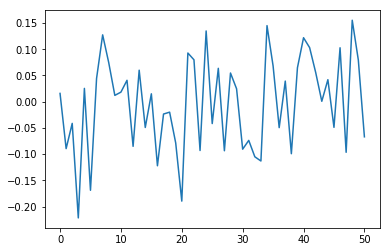

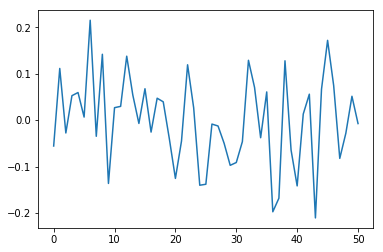

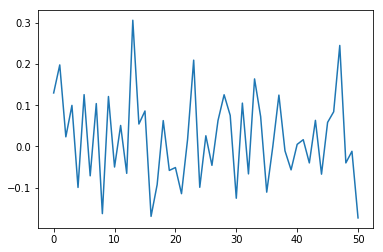

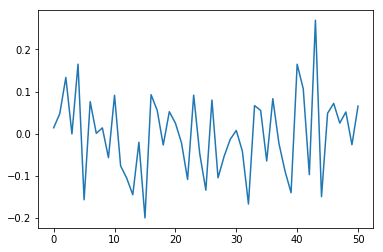

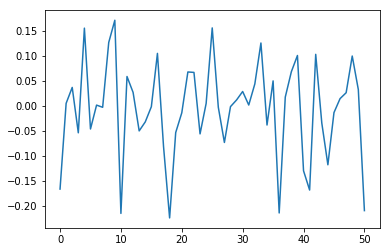

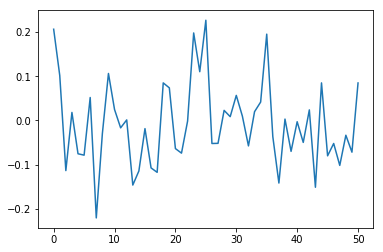

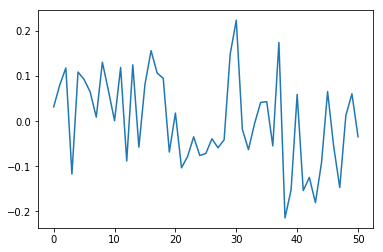

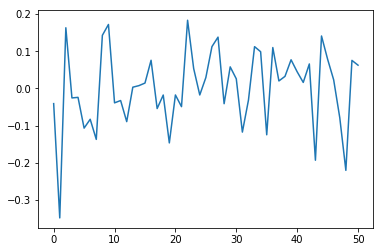

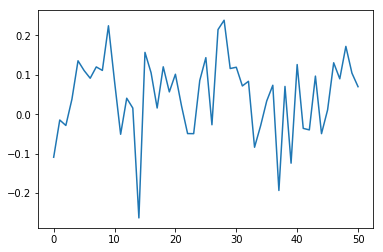

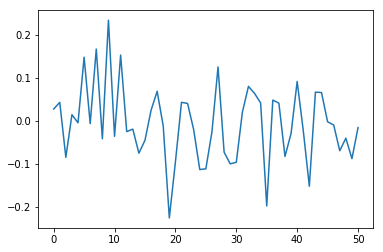

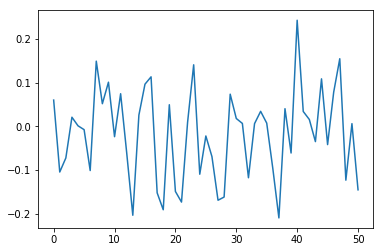

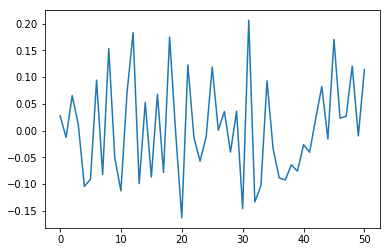

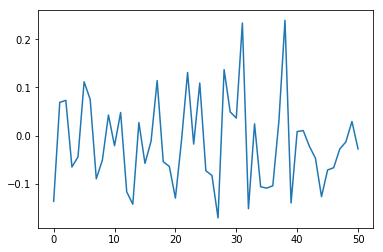

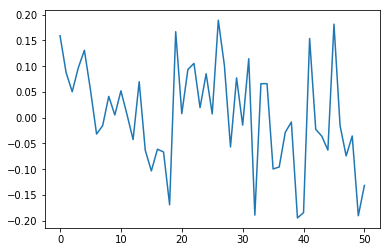

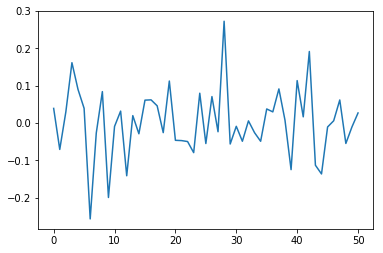

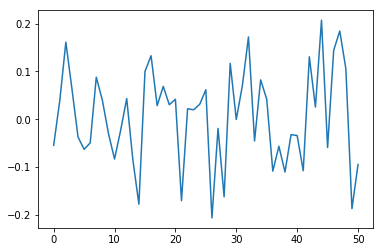

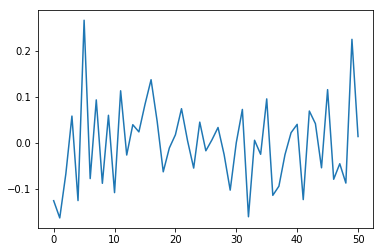

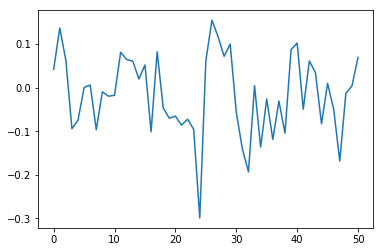

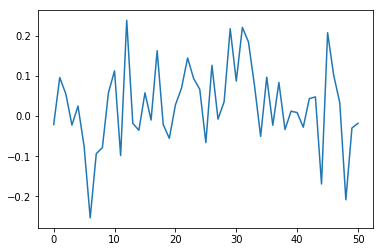

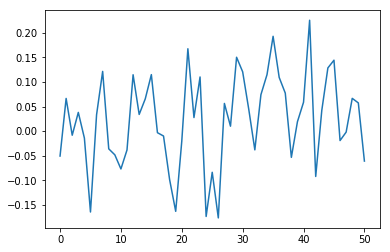

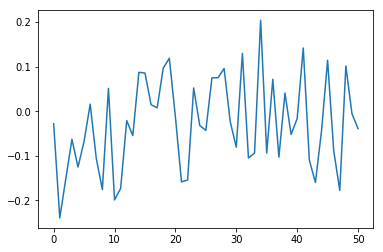

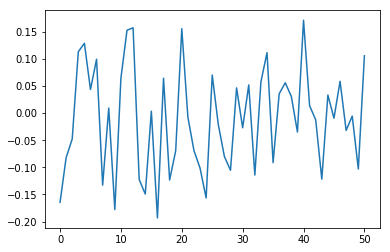

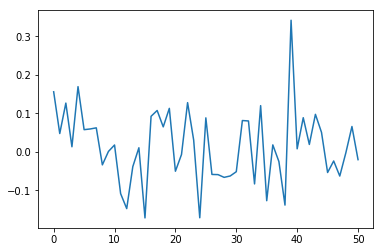

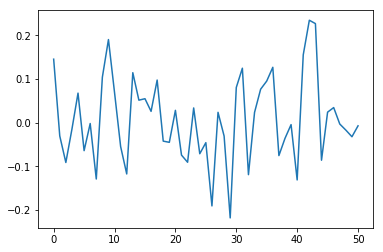

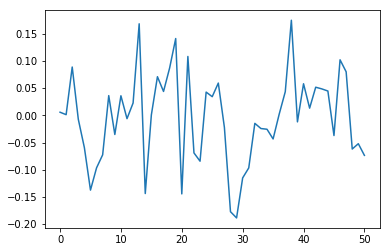

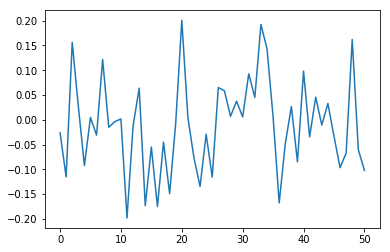

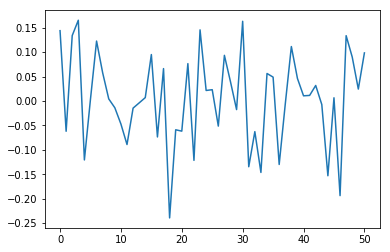

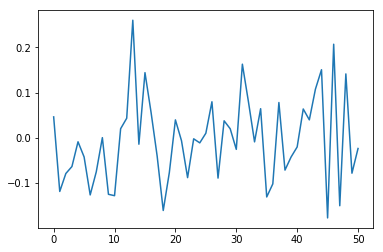

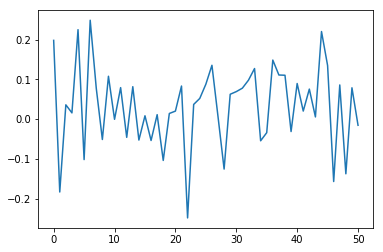

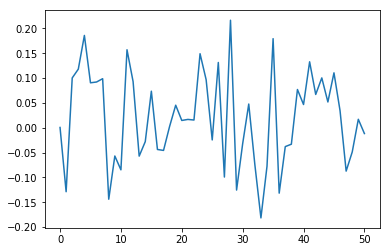

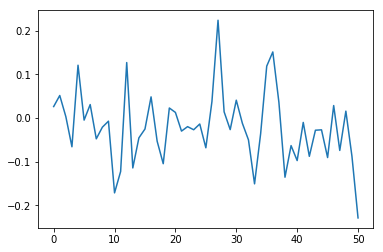

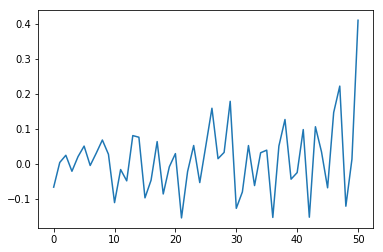

In [32]:

test=(0.5*(O_1@O_1 + O_2@O_2)).real
for i in range(test.shape[1]):
    plt.plot(test[:,i])
    plt.show()

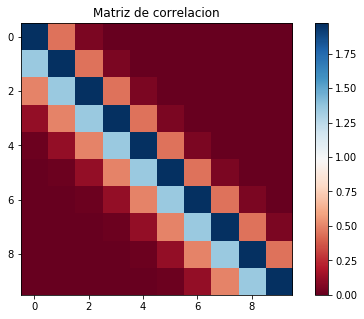

In [33]:
a_0=Lambda
a_1=0.5*(1-Gamma)
a_2=0.5*(1+Gamma)
A=np.zeros((L,L))
for i in range(L):
    for j in range(L):
        if i==j:
            A[i,j] = a_0
        elif (i-j) % L == 1:
            A[i,j] = a_2
        elif (j-i) % L == 1:
            A[i,j] = a_1
plt.figure(figsize=(8,5))
plt.imshow(expm(A)[:10,:10],cmap="RdBu")
plt.colorbar()
plt.title("Matriz de correlacion")
plt.show()

In [64]:
np.diagonal(rho.real)/np.diagonal(A)

array([1.96559682, 1.96595711, 1.96553187, 1.96533429, 1.96594689,
       1.9663511 , 1.96612659, 1.9661667 , 1.96698102, 1.96623823,
       1.96583997, 1.96657674, 1.96600796, 1.96623184, 1.96537674,
       1.96662235, 1.96607141, 1.96666511, 1.9659574 , 1.96575113,
       1.96608904, 1.96616538, 1.9661783 , 1.96563734, 1.96517373,
       1.96614301, 1.96622995, 1.96695163, 1.96589187, 1.96605316,
       1.96624688, 1.96614199, 1.96592886, 1.96580118, 1.96541168,
       1.96595092, 1.96557539, 1.96617641, 1.96630422, 1.96620118,
       1.96600949, 1.96546914, 1.96563778, 1.96649049, 1.96602798,
       1.96618269, 1.96578875, 1.96639532, 1.96597966, 1.96617045,
       1.96597188])

In [65]:
a1=[]
a2=[]
for i in range(L):
    for j in range(L):
        if i-j==1:
            a1.append(rho[i,j].real)
        elif j-i==1:
            a2.append(rho[i,j].real)

In [66]:
a1,a2 = np.array(a1), np.array(a2)

In [67]:
A[1,0]/a1

array([-14.67541288, -14.64154435, -14.68847478, -14.68744719,
       -14.67336715, -14.75471303, -14.59895219, -14.67908888,
       -14.65097549, -14.71976469, -14.62318279, -14.73310977,
       -14.70194916, -14.68365841, -14.65982864, -14.61701278,
       -14.59554304, -14.6473022 , -14.60788702, -14.54726703,
       -14.66278422, -14.56984972, -14.70351605, -14.7120709 ,
       -14.64567455, -14.70459751, -14.64346028, -14.67954648,
       -14.70694523, -14.65652951, -14.49598108, -14.67152875,
       -14.69191269, -14.75432395, -14.60463354, -14.63097536,
       -14.63818541, -14.71025683, -14.77554216, -14.64387889,
       -14.63989633, -14.72786603, -14.76142778, -14.63931716,
       -14.66945642, -14.68613666, -14.62021594, -14.64567106,
       -14.61659004, -14.783401  ])

In [68]:
A[0,1]/a2

array([-33.45018383, -33.00798929, -33.73628773, -33.72448235,
       -33.50501038, -34.81739192, -32.37322293, -33.59151116,
       -33.154175  , -34.24532368, -32.7357498 , -34.46454696,
       -33.95503489, -33.66282101, -33.29051635, -32.63921696,
       -32.31936155, -33.09547909, -32.50553736, -31.6253301 ,
       -33.33868686, -31.95037867, -33.9828946 , -34.12259353,
       -33.0803379 , -34.00514123, -33.04696378, -33.60408536,
       -34.036819  , -33.24085587, -30.91372508, -33.47601349,
       -33.78975377, -34.80650897, -32.45441793, -32.84852913,
       -32.95668294, -34.091261  , -35.16997318, -33.0510295 ,
       -32.98864693, -34.37503278, -34.92839847, -32.97550594,
       -33.44383357, -33.70310182, -32.68491943, -33.07141142,
       -32.61754151, -35.2288177 ])

In [15]:
def algo(x):
    return 1/(x-1)

In [16]:
def otro_algo(y):
    return algo(y)+1

In [18]:
otro_algo(1)

ZeroDivisionError: division by zero

In [21]:
%debug

> <ipython-input-15-f6a6c49dd9ba>(2)algo()
      1 def algo(x):
----> 2     return 1/(x-1)

ipdb> i
50
ipdb> 20
20
ipdb> a
x = 1
ipdb> 1
1
ipdb> y
*** NameError: name 'y' is not defined
ipdb> q


In [22]:
from pdb import set_trace

In [23]:
for ii in range(5):
    set_trace()
    print(ii)

> <ipython-input-23-3b9d04401194>(3)<module>()
-> print(ii)
(Pdb) ii
0
(Pdb) 
0
(Pdb) 
0
(Pdb) continue
0
> <ipython-input-23-3b9d04401194>(2)<module>()
-> set_trace()
(Pdb) i
50
(Pdb) next
> <ipython-input-23-3b9d04401194>(3)<module>()
-> print(ii)
(Pdb) q


BdbQuit: 